## 数据处理

数据处理包含五个部分：数据导入、数据形状变换、数据集划分、数据归一化处理和封装`load data`函数。数据预处理后，才能被模型调用。

### 读入数据

通过如下代码读入数据，了解下波士顿房价的数据集结构，数据存放在本地目录下housing.data文件中。

In [1]:
# 导入需要用到的package
import numpy as np
import json
# 读入训练数据
datafile = './work/housing.data'
data = np.fromfile(datafile, sep=' ')
data

array([6.320e-03, 1.800e+01, 2.310e+00, ..., 3.969e+02, 7.880e+00,
       1.190e+01])

### 数据形状变换

由于读入的原始数据是1维的，所有数据都连在一起。因此需要我们将数据的形状进行变换，形成一个2维的矩阵，每行为一个数据样本（14个值），每个数据样本包含13个$X$（影响房价的特征）和一个$Y$（该类型房屋的均价）。

In [2]:
# 读入之后的数据被转化成1维array，其中array的第0-13项是第一条数据，第14-27项是第二条数据，以此类推.... 
# 这里对原始数据做reshape，变成N x 14的形式
feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 
                 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
feature_num = len(feature_names)
data = data.reshape([data.shape[0] // feature_num, feature_num])

In [3]:
# 查看数据
x = data[0]
print(x.shape)
print(x)

(14,)
[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00 2.400e+01]


### 数据集划分

将数据集划分成训练集和测试集，其中训练集用于确定模型的参数，测试集用于评判模型的效果。

我们将80%的数据用作训练集，20%用作测试集，实现代码如下。通过打印训练集的形状，可以发现共有404个样本，每个样本含有13个特征和1个预测值。

In [4]:
ratio = 0.8
offset = int(data.shape[0] * ratio)
training_data = data[:offset]
training_data.shape

(404, 14)

### 数据归一化处理

对每个特征进行归一化处理，使得每个特征的取值缩放到0~1之间。这样做有两个好处：一是模型训练更高效；二是特征前的权重大小可以代表该变量对预测结果的贡献度（因为每个特征值本身的范围相同）。

In [5]:
# 计算train数据集的最大值，最小值，平均值
maximums, minimums, avgs = \
                     training_data.max(axis=0), \
                     training_data.min(axis=0), \
     training_data.sum(axis=0) / training_data.shape[0]
# 对数据进行归一化处理
for i in range(feature_num):
    #print(maximums[i], minimums[i], avgs[i])
    data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

### 封装成load data函数

将上述几个数据处理操作封装成`load data`函数，以便下一步模型的调用，实现方法如下。

In [6]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [7]:
# 获取数据
training_data, test_data = load_data()
x = training_data[:, :-1]
y = training_data[:, -1:]

In [8]:
# 查看数据
print(x[0])
print(y[0])

[0.         0.18       0.07344184 0.         0.31481481 0.57750527
 0.64160659 0.26920314 0.         0.22755741 0.28723404 1.
 0.08967991]
[0.42222222]


## 模型设计

模型设计是深度学习模型关键要素之一，也称为网络结构设计，相当于模型的假设空间，即实现模型“前向计算”（从输入到输出）的过程。

如果将输入特征和输出预测值均以向量表示，输入特征$x$有13个分量，$y$有1个分量，那么参数权重的形状（shape）是$13\times1$。假设我们以如下任意数字赋值参数做初始化：
$$w=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, -0.1, -0.2, -0.3, -0.4, 0.0]$$

In [9]:
w = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, -0.1, -0.2, -0.3, -0.4, 0.0]
w = np.array(w).reshape([13, 1])

取出第1条样本数据，观察样本的特征向量与参数向量相乘的结果。

In [10]:
x1=x[0]
t = np.dot(x1, w)
print(t)

[0.69474855]


完整的线性回归公式，还需要初始化偏移量$b$，同样随意赋初值-0.2。那么，线性回归模型的完整输出是$z=t+b$，这个从特征和参数计算输出值的过程称为“前向计算”。

In [11]:
b = -0.2
z = t + b
print(z)

[0.49474855]


将上述计算预测输出的过程以“类和对象”的方式来描述，类成员变量有参数$w$和$b$。通过写一个`forward`函数（代表“前向计算”）完成上述从特征和参数到输出预测值的计算过程，代码如下所示。

In [12]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，
        # 此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z

基于Network类的定义，模型的计算过程如下所示。

In [13]:
net = Network(13)
x1 = x[0]
y1 = y[0]
z = net.forward(x1)
print(z)

[2.39362982]


## 训练配置

模型设计完成后，需要通过训练配置寻找模型的最优值，即通过损失函数来衡量模型的好坏。训练配置也是深度学习模型关键要素之一。

通过模型计算$x_1$表示的影响因素所对应的房价应该是$z$, 但实际数据告诉我们房价是$y$。这时我们需要有某种指标来衡量预测值$z$跟真实值$y$之间的差距。对于回归问题，最常采用的衡量方法是使用均方误差作为评价模型好坏的指标，具体定义如下：

$$Loss = (y - z)^2$$

上式中的$Loss$（简记为: $L$）通常也被称作损失函数，它是衡量模型好坏的指标。在回归问题中，均方误差是一种比较常见的形式，分类问题中通常会采用交叉熵作为损失函数，在后续的章节中会更详细的介绍。对一个样本计算损失函数值的实现如下：

In [14]:
Loss = (y1 - z)*(y1 - z)
print(Loss)

[3.88644793]


因为计算损失函数时需要把每个样本的损失函数值都考虑到，所以我们需要对单个样本的损失函数进行求和，并除以样本总数$N$。
$$Loss= \frac{1}{N}\sum_{i=1}^N{(y_i - z_i)^2}$$
在Network类下面添加损失函数的计算过程如下：

In [15]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        cost = error * error
        cost = np.mean(cost)
        return cost


使用定义的Network类，可以方便的计算预测值和损失函数。需要注意的是，类中的变量$x$, $w$，$b$, $z$, $error$等均是向量。以变量$x$为例，共有两个维度，一个代表特征数量（值为13），一个代表样本数量，代码如下所示。

In [16]:
net = Network(13)
# 此处可以一次性计算多个样本的预测值和损失函数
x1 = x[0:3]
y1 = y[0:3]
z = net.forward(x1)
print('predict: ', z)
loss = net.loss(z, y1)
print('loss:', loss)

predict:  [[2.39362982]
 [2.46752393]
 [2.02483479]]
loss: 3.384496992612791


## 训练过程

上述计算过程描述了如何构建神经网络，通过神经网络完成预测值和损失函数的计算。接下来介绍如何求解参数$w$和$b$的数值，这个过程也称为模型训练过程。训练过程是深度学习模型的关键要素之一，其目标是让定义的损失函数$Loss$尽可能的小，也就是说找到一个参数解$w$和$b$，使得损失函数取得极小值。

处于曲线极值点时的斜率为0，即函数在极值点的导数为0。那么，让损失函数取极小值的$w$和$b$应该是下述方程组的解：
$$\frac{\partial{L}}{\partial{w}}=0$$
$$\frac{\partial{L}}{\partial{b}}=0$$

将样本数据$(x, y)$带入上面的方程组中即可求解出$w$和$b$的值，但是这种方法只对线性回归这样简单的任务有效。如果模型中含有非线性变换，或者损失函数不是均方差这种简单的形式，则很难通过上式求解。为了解决这个问题，下面我们将引入更加普适的数值求解方法：梯度下降法。

### 梯度下降法

在现实中存在大量的函数正向求解容易，但反向求解较难，被称为单向函数。

训练的关键是找到一组$(w, b)$，使得损失函数$L$取极小值。

### 计算梯度

为了使梯度计算更加简洁，引入因子$\frac{1}{2}$，定义损失函数如下：

$$L= \frac{1}{2N}\sum_{i=1}^N{(y_i - z_i)^2}$$

其中$z_i$是网络对第$i$个样本的预测值：

$$z_i = \sum_{j=0}^{12}{x_i^{j}\cdot w_j} + b$$

梯度的定义：

$$𝑔𝑟𝑎𝑑𝑖𝑒𝑛𝑡 = (\frac{\partial{L}}{\partial{w_0}},\frac{\partial{L}}{\partial{w_1}}, ... ,\frac{\partial{L}}{\partial{w_{12}}} ,\frac{\partial{L}}{\partial{b}})$$

可以计算出$L$对$w$和$b$的偏导数：

$$\frac{\partial{L}}{\partial{w_j}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)\frac{\partial{z_i}}{\partial{w_j}}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)x_i^{j}}$$

$$\frac{\partial{L}}{\partial{b}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)\frac{\partial{z_i}}{\partial{b}}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)}$$

从导数的计算过程可以看出，因子$\frac{1}{2}$被消掉了，这是因为二次函数求导的时候会产生因子$2$，这也是我们将损失函数改写的原因。

下面我们考虑只有一个样本的情况下，计算梯度：

$$L= \frac{1}{2}{(y_i - z_i)^2}$$

$$z_1 = {x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_{12}} + b$$

可以计算出：

$$L= \frac{1}{2}{({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_{12}} + b - y_1)^2}$$

可以计算出$L$对$w$和$b$的偏导数：

$$\frac{\partial{L}}{\partial{w_0}} = ({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_12} + b - y_1)\cdot x_1^{0}=({z_1} - {y_1})\cdot x_1^{0}$$

$$\frac{\partial{L}}{\partial{b}} = ({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_{12}} + b - y_1)\cdot 1 = ({z_1} - {y_1})$$


### 使用Numpy进行梯度计算

基于Numpy广播机制（对向量和矩阵计算如同对1个单一变量计算一样），可以更快速的实现梯度计算。

综合上面的剖析，计算梯度的代码如下所示。

In [30]:
z = net.forward(x)
gradient_w = (z - y) * x
gradient_w = np.mean(gradient_w, axis=0)
gradient_w = gradient_w[:, np.newaxis]
gradient_w

array([[  4.6555403 ],
       [ 19.35268996],
       [ 55.88081118],
       [ 14.00266972],
       [ 47.98588869],
       [ 76.87210821],
       [ 94.8555119 ],
       [ 36.07579608],
       [ 45.44575958],
       [ 59.65733292],
       [ 83.65114918],
       [134.80387478],
       [ 38.93998153]])

上述代码非常简洁地完成了$w$的梯度计算。同样，计算$b$的梯度的代码也是类似的原理。

In [31]:
gradient_b = (z - y)
gradient_b = np.mean(gradient_b)
# 此处b是一个数值，所以可以直接用np.mean得到一个标量
gradient_b

142.50289323156107

将上面计算$w$和$b$的梯度的过程，写成Network类的`gradient`函数，实现方法如下所示。

In [32]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)
        
        return gradient_w, gradient_b

In [33]:
# 调用上面定义的gradient函数，计算梯度
# 初始化网络
net = Network(13)
# 设置[w5, w9] = [-100., -100.]
net.w[5] = -100.0
net.w[9] = -100.0

z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))


point [-100.0, -100.0], loss 7873.345739941161
gradient [-45.87968288123223, -35.50236884482904]


### 确定损失函数更小的点

下面我们开始研究更新梯度的方法。首先沿着梯度的反方向移动一小步，找到下一个点P1，观察损失函数的变化。

In [34]:
# 在[w5, w9]平面上，沿着梯度的反方向移动到下一个点P1
# 定义移动步长 eta
eta = 0.1
# 更新参数w5和w9
net.w[5] = net.w[5] - eta * gradient_w5
net.w[9] = net.w[9] - eta * gradient_w9
# 重新计算z和loss
z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))

point [-95.41203171187678, -96.4497631155171], loss 7214.694816482369
gradient [-43.883932999069096, -34.019273908495926]


运行上面的代码，可以发现沿着梯度反方向走一小步，下一个点的损失函数的确减少了。感兴趣的话，大家可以尝试不停的点击上面的代码块，观察损失函数是否一直在变小。

在上述代码中，每次更新参数使用的语句：
`net.w[5] = net.w[5] - eta * gradient_w5`

* 相减：参数需要向梯度的反方向移动。
* eta：控制每次参数值沿着梯度反方向变动的大小，即每次移动的步长，又称为学习率。

大家可以思考下，为什么之前我们要做输入特征的归一化，保持尺度一致？这是为了让统一的步长更加合适。


###  代码封装Train函数

将上面的循环计算过程封装在`train`和`update`函数中，实现方法如下所示。

iter 0, point [-99.54120317118768, -99.64497631155172], loss 7873.345739941161
iter 50, point [-78.9761810944732, -83.65939206734069], loss 5131.480704109405
iter 100, point [-62.4493631356931, -70.67918223434114], loss 3346.754494352463
iter 150, point [-49.17799206644332, -60.12620415441553], loss 2184.906016270654
iter 200, point [-38.53070194231174, -51.533984751788346], loss 1428.4172504483342
iter 250, point [-29.998249130283174, -44.52613603923428], loss 935.7392894242679
iter 300, point [-23.169901624519575, -38.79894318028118], loss 614.7592258739251
iter 350, point [-17.71439280083778, -34.10731848231335], loss 405.53408184471505
iter 400, point [-13.364557220746388, -30.253470630210863], loss 269.0551396220099
iter 450, point [-9.904936677384967, -27.077764259976597], loss 179.9364750604248
iter 500, point [-7.161782280775628, -24.451346444229817], loss 121.65711285489998
iter 550, point [-4.994989383373879, -22.270198517465555], loss 83.46491706360901
iter 600, point [-3.29

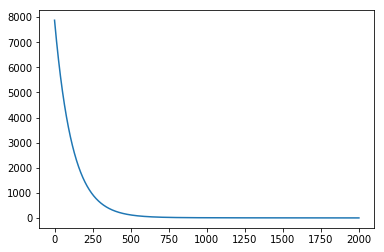

In [35]:
import matplotlib.pyplot as plt
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights,1)
        self.w[5] = -100.
        self.w[9] = -100.
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)        
        return gradient_w, gradient_b
    
    def update(self, gradient_w5, gradient_w9, eta=0.01):
        net.w[5] = net.w[5] - eta * gradient_w5
        net.w[9] = net.w[9] - eta * gradient_w9
        
    def train(self, x, y, iterations=100, eta=0.01):
        points = []
        losses = []
        for i in range(iterations):
            points.append([net.w[5][0], net.w[9][0]])
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            gradient_w5 = gradient_w[5][0]
            gradient_w9 = gradient_w[9][0]
            self.update(gradient_w5, gradient_w9, eta)
            losses.append(L)
            if i % 50 == 0:
                print('iter {}, point {}, loss {}'.format(i, [net.w[5][0], net.w[9][0]], L))
        return points, losses

# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=2000
# 启动训练
points, losses = net.train(x, y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

### 训练扩展到全部参数

为了能给读者直观的感受，上面演示的梯度下降的过程仅包含$w_5$和$w_9$两个参数，但房价预测的完整模型，必须要对所有参数$w$和$b$进行求解。这需要将Network中的`update`和`train`函数进行修改。由于不再限定参与计算的参数（所有参数均参与计算），修改之后的代码反而更加简洁。实现逻辑：“前向计算输出、根据输出和真实值计算Loss、基于Loss和输入计算梯度、根据梯度更新参数值”四个部分反复执行，直到到损失函数最小。具体代码如下所示。

iter 9, loss 5.143394325795511
iter 19, loss 3.097924194225988
iter 29, loss 2.082241020617026
iter 39, loss 1.5673801618157397
iter 49, loss 1.2966204735077431
iter 59, loss 1.1453399043319765
iter 69, loss 1.0530155717435201
iter 79, loss 0.9902292156463155
iter 89, loss 0.9426576903842504
iter 99, loss 0.9033048096880774
iter 109, loss 0.868732003041364
iter 119, loss 0.837229250968144
iter 129, loss 0.807927474161227
iter 139, loss 0.7803677341465797
iter 149, loss 0.7542920908532763
iter 159, loss 0.7295420168915829
iter 169, loss 0.7060090054240882
iter 179, loss 0.6836105084697767
iter 189, loss 0.6622781710179412
iter 199, loss 0.6419520361168637
iter 209, loss 0.622577651786949
iter 219, loss 0.6041045903195837
iter 229, loss 0.5864856570315078
iter 239, loss 0.5696764374763879
iter 249, loss 0.5536350125932015
iter 259, loss 0.5383217588525027
iter 269, loss 0.5236991929680567
iter 279, loss 0.509731841376165
iter 289, loss 0.4963861247069634
iter 299, loss 0.4836302523439023

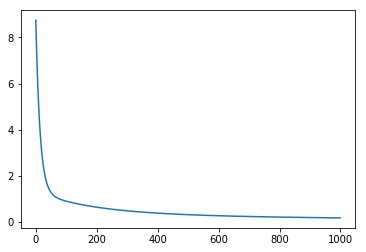

In [36]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)        
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
        
    def train(self, x, y, iterations=100, eta=0.01):
        losses = []
        for i in range(iterations):
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            self.update(gradient_w, gradient_b, eta)
            losses.append(L)
            if (i+1) % 10 == 0:
                print('iter {}, loss {}'.format(i, L))
        return losses

# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=1000
# 启动训练
losses = net.train(x,y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()
